# **Single material point simulation - pure shear in elastic material**

In [1]:
%matplotlib widget
from bmcs_matmod.msx import MSX
import matplotlib.pylab as plt
import numpy as np
np.seterr(divide='ignore', invalid='ignore');
from bmcs_matmod.msx.energy_dissipation import EnergyDissipation
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from ibvpy.api import XDomainSinglePoint, MATS3DScalarDamage, TStepBC, BCDof
from ibvpy.tmodel.mats3D import MATS3DElastic
from ibvpy.mathkit.linalg.dense_mtx import DenseMtx

In [2]:
m_elastic = MATS3DElastic()

In [3]:
xmodel = XDomainSinglePoint()
m = TStepBC(
    domains=[(xmodel, m_elastic),],
    bc=[BCDof(
            var='u', dof=3, value=-0.01)]
)

m.sim.tline.trait_set(step=0.1)
m.sim.reset()
m.sim.run()

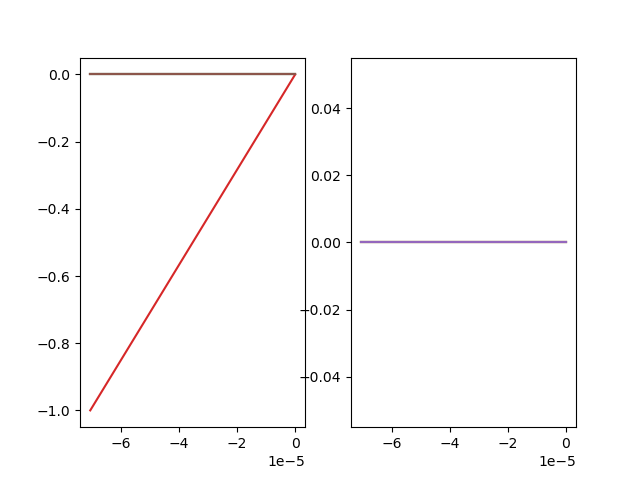

In [32]:
%matplotlib widget
import matplotlib.pylab as plt
fig, ((ax1,ax2)) = plt.subplots(1, 2)
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,0])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,1])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,2])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,3])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,4])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,5])

ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,0])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,1])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,2])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,4])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,5])

# Shear foce control

In [34]:
xmodel = XDomainSinglePoint()
m = TStepBC(
    domains=[(xmodel, m_elastic),],
    bc=[BCDof(
            var='f', dof=3, value=-1)]
)
m.sim.reset()

In [35]:
m.sim.tline.trait_set(step=0.1)
m.sim.reset()
m.sim.run()

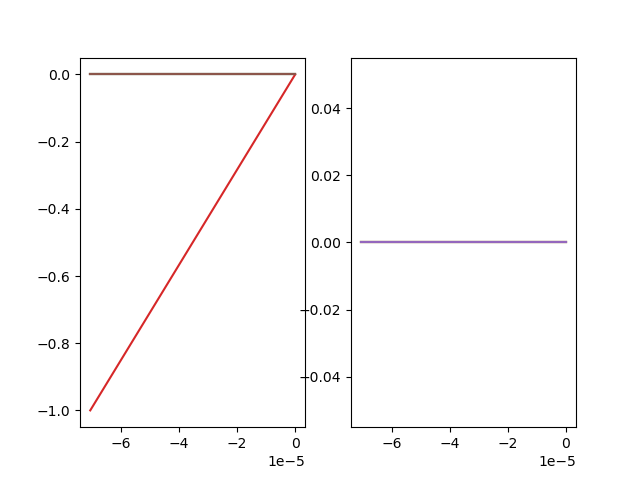

In [36]:
%matplotlib widget
import matplotlib.pylab as plt
fig, ((ax1,ax2)) = plt.subplots(1, 2)
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,0])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,1])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,2])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,3])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,4])
ax1.plot(m.hist.U_t[:,3], m.hist.F_t[:,5])

ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,0])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,1])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,2])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,4])
ax2.plot(m.hist.U_t[:,3], m.hist.U_t[:,5])

# Debugging section

In [37]:
xmodel = XDomainSinglePoint()
m = TStepBC(
    domains=[(xmodel, m_elastic),],
    bc=[BCDof(
            var='f', dof=3, value=-1)]
)
m.sim.reset()

In [38]:
self = m.sim.tstep

In [39]:
self.t_n, self.t_n1 = 0, 1

In [40]:
self.K.reset_mtx()
f_Eis, K_ks, dof_Es = np.array(
    [s.get_corr_pred(self.U_k, self.t_n, self.t_n1)
     for s in self.fe_domain], dtype=object).T
f_Eis, K_ks, dof_Es

(array([array([[0., 0., 0., 0., 0., 0.]])], dtype=object),
 array([<ibvpy.mathkit.linalg.sys_mtx_array.SysMtxArray object at 0x7f18f0f0e450>],
       dtype=object),
 array([array([0, 1, 2, 3, 4, 5])], dtype=object))

In [41]:
self.K.sys_mtx_arrays = list(K_ks)  # improve
self.K.n_dofs

6

In [42]:
F_ext = np.zeros_like(self.U_k)
self.bcond_mngr.apply(
    self.step_flag, None, self.K, F_ext, self.t_n, self.t_n1
)
F_ext

array([ 0.,  0.,  0., -1.,  0.,  0.])

In [43]:
F_int = np.bincount(
    np.hstack(np.hstack(dof_Es)),
    weights=np.hstack(np.hstack(f_Eis))
)
F_int

array([0., 0., 0., 0., 0., 0.])

In [44]:
R = F_ext - F_int
self.K.apply_constraints(R)
R

array([ 0.,  0.,  0., -1.,  0.,  0.])

In [45]:
dm = DenseMtx(assemb=self.K), R

In [46]:
'''Perform a single iteration
'''
d_U_k, pos_def = self.K.solve(check_pos_def=True)
if self.debug:
    print('positive definite', pos_def)
self.U_k[:] += d_U_k
self.primary_var_changed = True
self.step_flag = 'corrector'
self.U_k

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.05882353e-05,
        0.00000000e+00,  0.00000000e+00])

In [47]:
du = np.linalg.solve(dm[0].mtx, dm[1])
dm

(array([[37777.77777778,  9444.44444444,  9444.44444444,     0.        ,
             0.        ,     0.        ],
        [ 9444.44444444, 37777.77777778,  9444.44444444,     0.        ,
             0.        ,     0.        ],
        [ 9444.44444444,  9444.44444444, 37777.77777778,     0.        ,
             0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , 14166.66666667,
             0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        ,     0.        ,
         14166.66666667,     0.        ],
        [    0.        ,     0.        ,     0.        ,     0.        ,
             0.        , 14166.66666667]]),
 array([ 0.,  0.,  0., -1.,  0.,  0.]))

In [48]:
np.einsum('...a,a->...', dm[0].mtx, du)

array([ 0.,  0.,  0., -1.,  0.,  0.])

##  end debug